In [59]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scienceplots

# Add this path to use SciencePlots (it uses latex)
os.environ["PATH"] += os.pathsep + "/Library/TeX/texbin"

plt.rcParams["figure.figsize"] = (30,30)
plt.style.use(['science', 'notebook'])
pd.set_option('display.max_columns', None)


def calculate_count_ocurrences_in_genre(df, genre):
    return df[genre].value_counts()[1]

def calculate_count_ocurrences(df):
    names = ["unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary",
             "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller",
             "War", "Western"]
    ocurrences = []
    for name in names:
        ocurrences.append(calculate_count_ocurrences_in_genre(df, name))
    return np.asarray(names), np.asarray(ocurrences)
    

BASE_PATH = "../ml-100k"

ratings_column_names = ["user_id", "item_id", "rating", "timestamp"]
item_genres_column_names = ["genre", "id"]
item_information_column_names = ["item_id", "item_name", "date", "none", "url", "unknown", "Action", "Adventure",
                           "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama",
                           "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance",
                           "Sci-Fi", "Thriller", "War", "Western"]

u_data_path = os.path.join(BASE_PATH, "u.data")
u_genre = os.path.join(BASE_PATH, "u.genre")
u_item = os.path.join(BASE_PATH, "u.item")

data = pd.read_csv(u_data_path, sep="\t", header=None, names=["user_id", "item_id", "rating", "timestamp"])
genres = pd.read_csv(u_genre, sep="|", header=None, names=item_genres_column_names)
item_information = pd.read_csv(u_item, sep="|", header=None, names=item_information_column_names)

In [60]:
data.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [61]:
genres.head()

,genre,id
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [62]:
item_information.head()

,item_id,item_name,date,none,url,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


# Calculation of the frequencies of each gender

This is a simple visualization of the number of films within each genre (**as each film can belong to more than one category, the sum is not equal to the total number of films**).

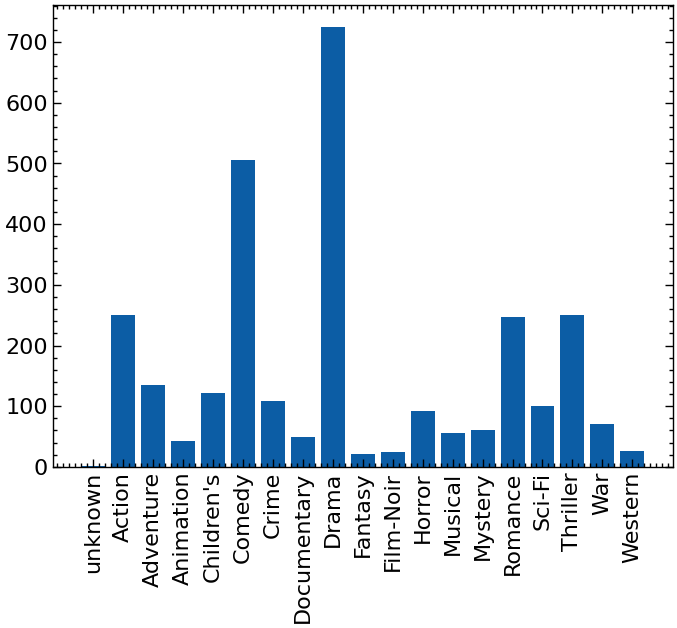

In [63]:
genre_names, genre_frequencies = calculate_count_ocurrences(item_information)

plt.bar(genre_names, genre_frequencies)
plt.xticks(genre_names, rotation='vertical')
plt.show()

We can see that the most represented category (almost 50%) is Drama, followed by Comedy. 

# Construction of ratings matrix

The ratings matrix is constructed and key statistics are extracted (average vote on all ratings, average vote on each movie, distribution of ratings per user, distribution of item ratings, etc.).

In [64]:
r = data.pivot(index='user_id', columns='item_id', values='rating').values

In [65]:
r_shape = r.shape

In [66]:
print("Rating matrix shape: ", r_shape)
print("Number of missing values: ", np.sum(np.isnan(r)))
print("Percentage of missing values: ", np.sum(np.isnan(r)) / (r_shape[0] * r_shape[1]))

Rating matrix shape:  (943, 1682)
Number of missing values:  1486126
Percentage of missing values:  0.9369533063577546


The ratings matrix, R, of dimension 943 x 1682, i.e. 943 users and 1682 items. On the other hand, we see that 93.7% of the values of the matrix are "missing values". That is to say, **it is a clearly "sparse" matrix**, something obvious since it is a ratings matrix. The number of ratings is 100000 (hence the name of the dataset).

Here are some interesting statistics to get an idea of the structure of the matrix.

In [75]:
print("Average rating in all Movielens 100K: ", np.nanmean(r))
print("Max / Min rating: ", np.nanmin(r), np.nanmax(r))

Average rating in all Movielens 100K:  3.52986
Max / Min rating:  1.0 5.0


In [76]:
number_of_ratings_per_user = np.sum(~ np.isnan(r), axis=1)

In [77]:
print("Mean of ratings per user: ", np.mean(number_of_ratings_per_user))
print("Quantiles of ratings per user: ", np.quantile(number_of_ratings_per_user,
                                                     q=[0.0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.]))

Mean of ratings per user:  106.04453870625663
Quantiles of ratings per user:  [ 20.   21.   33.   65.  148.  310.6 737. ]


We can see how the distribution of ratings is very distorted due to outliers (users who have rated many movies). **This makes that the mean is 106 while the median is 65**. Let's plot the number of ratings per user in a histogram.

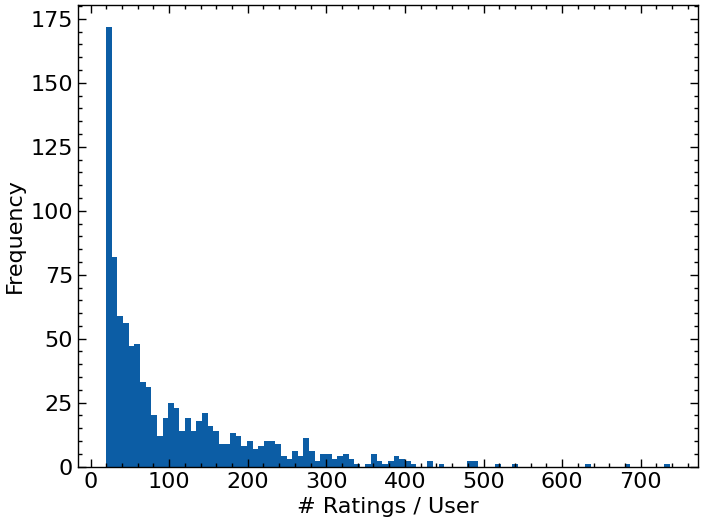

In [85]:
plt.hist(number_of_ratings_per_user, bins=100)
plt.xlabel("# Ratings / User")
plt.ylabel("Frequency")
plt.show()

Now, let's analyze the number of ratings per item.

In [82]:
number_of_ratings_per_item = np.sum(~ np.isnan(r), axis=0)

In [83]:
print("Mean of ratings per item: ", np.mean(number_of_ratings_per_item))
print("Quantiles of ratings per item: ", np.quantile(number_of_ratings_per_item,
                                                     q=[0.0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.]))

Mean of ratings per item:  59.45303210463734
Quantiles of ratings per item:  [  1.     1.     6.    27.    80.   229.85 583.  ]


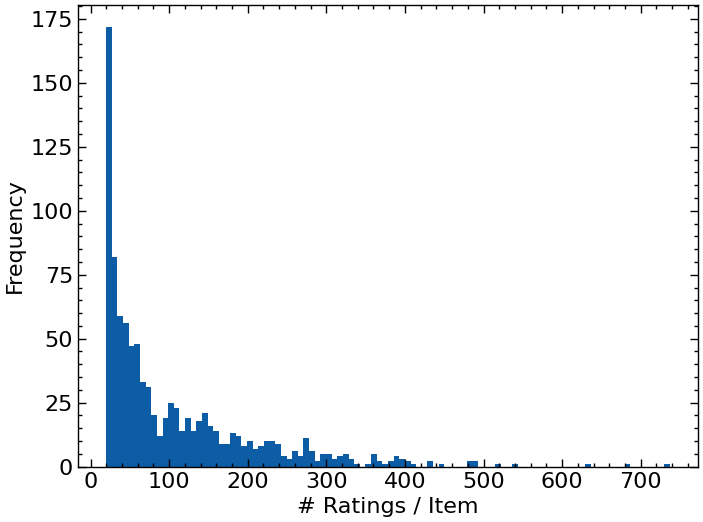

In [86]:
plt.hist(number_of_ratings_per_user, bins=100)
plt.xlabel("# Ratings / Item")
plt.ylabel("Frequency")
plt.show()

It can be interpreted as the classic longtail distribution, where we have that the majority of items have very little following by the community, while there is a select subset that has a large following. Let's look at it with another plot, in this case trying to show this popularity as the number of ratings received.

Text(0, 0.5, '# Ratings')

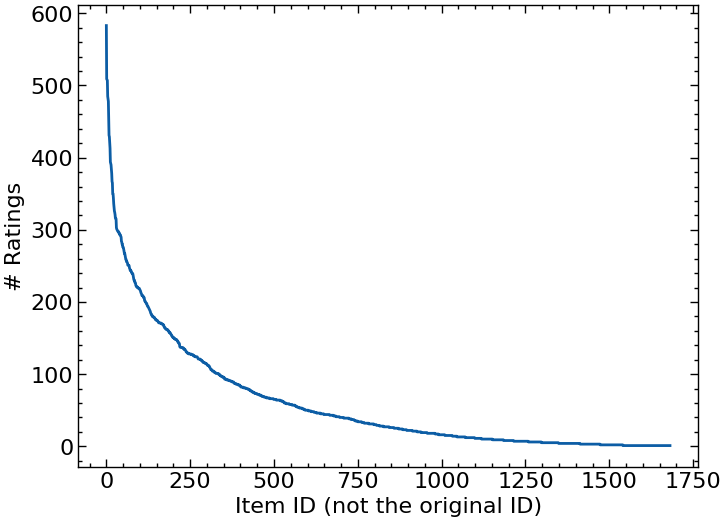

In [91]:
plt.plot(np.sort(number_of_ratings_per_item)[::-1])
plt.xlabel("Item ID (not the original ID)")
plt.ylabel("# Ratings")

As we can see, the "popularity" among the items is clearly asymmetrical, with items with a very high notoriety and others that have very little following. One of the keys to "serendipity" is to dive into the "long-tail", the unknown region, in order to find recommendations that surprise the user.